### HW2 part 4  : Executive summary 

"Match positionally the HLC and NSC catalogs; analyze whether the 
two sets of proper motions are statistically consistent. In particular,
test whether accounting for proper motions decreases positional discrepancies, and whether HLC or NSC pm’s are better in this case.

Hint: need to decide on matching radius, be careful about the faint limit, non-gaussianity, does chi2dof become ~1?…""


In [57]:
# Imports 
from astropy.table import Table
from itertools import product 
from astropy.time import Time
from astroML.stats import sigmaG
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
from astropy.io import fits
import pandas as pd

If you already have cross-matched NSC, HLC catalogs, go to [step 2](#step2) , or [step 3](#step3a). Check if we did : 

In [3]:
test_for_catalogs = [s for s in os.listdir() if s.startswith('hlc_nsc_')]
if len(test_for_catalogs) > 0 : 
    print('There are following files that look like cross-matched HLC-NSC catalogs:')
    print(test_for_catalogs)
    print('You may go to step 2, or even step 3 ')
else : 
    print('I do not see any files that start with "hlc_nsc*" that could be \
cross-matched HLC-NSC catalogs ... ')
    print('Need to run step 1')

There are following files that look like cross-matched HLC-NSC catalogs:
['hlc_nsc_1arcsec_2765649_main.npy', 'hlc_nsc_1arcsec_2765649_auxiliary.npy']
You may go to step 2, or even step 3 


If you already cross-matched GAIA, NSC and HLC catalogs, go to [Step 3b](#step3b)

Table of Contents <a id='toc'></a> :

[Step 1 Crossmatch NSC and HLC](#step1)

[Step 2 Compare NSC. HLC Proper Motions](#step2)

[Step 3 Add GAIA data:](#step3a)
  * [Step3a Crossmatch GAIA to NSC-HLC](#step3a)
  * [Step3b Use pre-crossmatched GAIA-NSC-HLC catalog](#step3b)

## 1) Load NSC,  HLC, and crossmatch <a id='step1'></a>

[Go to top](#toc)

In [ ]:
# Load the NSC data ... 
table_neg = Table.read('NSC_stripe82_Dec_negative.csv')
table_pos = Table.read('NSC_stripe82_Dec_positive.csv')

In [ ]:
# Stack the two tables vertically 
nsc = vstack([table_neg, table_pos])
print('Done')

In [ ]:
# Read in the HLC data : 
catalogs = ['HLC.RA_20_to_21.fits.gz',
'HLC.RA_21_to_22.fits.gz',
'HLC.RA_22_to_23.fits.gz',
'HLC.RA_23_to_24.fits.gz',
'HLC.RA_00_to_01.fits.gz',
'HLC.RA_01_to_02.fits.gz',
'HLC.RA_02_to_03.fits.gz',
'HLC.RA_03_to_04.fits.gz']


def ReadTable(name):
    dir_hlc = '../HW_1/'
    hlc_fits = fits.open(dir_hlc+name)
    hlc_table = Table(hlc_fits[1].data)
    return hlc_table

hlc = ReadTable(catalogs[0])
for catalog in catalogs[1:] : 
    print('Reading ', catalog)
    hlc_cat = ReadTable(catalog)
    hlc = vstack([hlc, hlc_cat])



In [ ]:
# Since S82 is centered on RA=0 , stretchin roughly +/- 50 degrees away
# it makes sense to change 0-360 to -180 / +180 .. 

coord = 'RA'
for col_type in  ['_MEAN','_MEAN_CLIP']:    
    c =coord+col_type
    hlc[c +'_W'] = np.where(hlc[c]>180, hlc[c]-360, hlc[c])

In [ ]:
# Do the same for the   NSC catalog 
nsc['raW'] = np.where(nsc['ra']>180, nsc['ra']-360, nsc['ra'])

In [ ]:
# Show the ra coverage of nsc vs hlc ....
%matplotlib inline
plt.hist(nsc['raW'], histtype='step', lw=2)
plt.hist(hlc['RA_MEAN_CLIP_W'], histtype='step', lw=2)

In [ ]:
# To make things faster, we split this range 
# into bins of RA 

ra_col  = 'RA_MEAN_CLIP_W' # choose which ra type to use for HLC 
hlc_nsc = Table()
ra = np.arange(-50,60,10)
for i in range(len(ra)-1):
    print('Matching ra in range ',ra[i], ra[i+1])
    mask_hlc = (ra[i]<hlc[ra_col])*(hlc[ra_col] < ra[i+1])
    mask_nsc = (ra[i]<nsc['raW'])*(nsc['raW'] < ra[i+1])
    
    hlc_sel = hlc[mask_hlc]
    nsc_sel = nsc[mask_nsc]
    
    hlc_coords = SkyCoord(ra=hlc_sel[ra_col]*u.degree, 
                          dec=hlc_sel['DEC_MEAN']*u.degree
                         )
    nsc_coords = SkyCoord(ra = nsc_sel['raW']*u.degree,  
                          dec = nsc_sel['dec']*u.degree
                         )
    
    idx, d2d, d3d = hlc_coords.match_to_catalog_sky(nsc_coords)  
    
    hlc_nsc_sel = hstack([hlc_sel, nsc_sel[idx]], table_names = ['hlc', 'nsc'])
    hlc_nsc_sel['sep_2d_arcsec'] = d2d.arcsec
    
    hlc_nsc = vstack([hlc_nsc_sel, hlc_nsc])
    
print('Finished crossmatching')    

In [ ]:
# plot the separation histogram ....
# there is a clean peak close to zero : 
# these are the matched sources 
x = hlc_nsc['sep_2d_arcsec']
plt.hist(x[x<1], histtype='step', lw=2 )

#  select matched sources 
x = hlc_nsc['sep_2d_arcsec']
matched = x < 1 
selected =  hlc_nsc[matched]

# How many of the hlc sources had a good match ? 
print(len(hlc), len(selected))

In [ ]:
# Since the above steps take quite a while, save the cross-matched table 
# with good matches ... 

# Check whether the file with cross-matched catalogs exists....
fname =  'hlc_nsc_1arcsec_'+str(len(selected))+'_main'
import os 
if fname not in os.listdir() : 
    print('Saving the cross-matched catalog main columns as ', fname )

    # store in this variable all columns of combined HLC-NSC catalog 
    all_cols = np.ravel(hlc_nsc.colnames)

    # explicitly choose which columns to save in the main cross-matched catalog 
    select_cols = ['LC_NAME', 'IAU_NAME', 'N_GOOD_EPOCHS', 'MEAN_PSFMAG',
           'MEAN_PSFMAG_ERR', 
           'N_GOOD_EPOCHS_PSF_CLIP', 
       'MEAN_PSFMAG_CLIP', 'MEAN_PSFMAG_ERR_CLIP', 
       'TIME_SPAN', 'MEAN_OBJECT_TYPE', 'REDDENING',
       'RA_MEAN_CLIP_W', 'RA_MEAN_ERR_CLIP', 'RA_PM_CLIP', 
       'RA_PM_ERR_CLIP', 'DEC_MEAN_CLIP', 'DEC_MEAN_ERR_CLIP',
       'DEC_PM_CLIP', 'DEC_PM_ERR_CLIP',
     'T0', 'T0_CLIP','N_POS_EPOCHS_CLIP', 'ECL_REDCHISQ_OUT', 'ECL_STAT', 'ECL_EPOCH',
       'ra', 'dec',
       'pmra', 'pmraerr', 'pmdec', 'pmdecerr', 'mjd', 'deltamjd', 'gmag',
       'grms', 'gerr', 'rmag', 'rrms', 'rerr', 'imag', 'irms', 'ierr',
       'class_star', 'fwhm', 'ebv', 'nphot', 'raW', 'sep_2d_arcsec']

    np.save(fname,selected[select_cols])

    # store all other columns in the auxiliary cross-matched catalog 
    other_cols = all_cols[~np.in1d(all_cols,select_cols)]
    fname =  'hlc_nsc_1arcsec_'+str(len(selected))+'_auxiliary'
    print('Saving the cross-matched catalog aux columns as ', fname )
    np.save(fname,selected[list(other_cols)])

    # it can be loaded into AstroPy as  
    #test = Table(np.load(fname))

## 2) Load the saved NSC-HLC cross-matched catalogs  <a id='step2'></a>

[Go to top](#toc)

In [ ]:
fname =  test_for_catalogs[0] # 'hlc_nsc_1arcsec_2765649_main'
selected = Table(np.load(fname))

In [ ]:
def FormatMagnitude(table):
    mean_psfmag = Table(table['MEAN_PSFMAG'], names=('u', 'g', 'r', 'i','z'))
    mean_psfmag_err = Table(table['MEAN_PSFMAG_ERR'], names=('u', 'g', 'r', 'i','z'))
    SN = {} #a dictionary
    for f in mean_psfmag.colnames : 
        SN[f] = mean_psfmag[f] / mean_psfmag_err[f]
    return mean_psfmag, mean_psfmag_err, SN

mean_psfmag, mean_psfmag_err, SN = FormatMagnitude(selected)

# select only high signal to noise :
mSN = (SN['g'] > 5) * ( SN['r'] > 5) * ( SN['i'] > 5 )
m_r = mean_psfmag['r'].data > 10.0

dra = 3600*(selected['RA_MEAN_CLIP_W'] - selected['raW']) 
ddec = 3600*(selected['DEC_MEAN_CLIP'] - selected['dec'])

We plot the raw difference in RA, DEC,  that clearly shows that the two catalogs measure different positions of stars. The following plots show that indeed there is a discrepancy...

In [ ]:
%matplotlib inline 
import seaborn as sns 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=True)

fig = plt.figure(figsize=(10, 7.5))

# First axis : the hexbin plot ... 
ax = fig.add_axes([0.35, 0.35, 0.45, 0.6], xticks=[], yticks=[])
im1 = ax.hexbin(dra, ddec, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-0.5, 0.5, -0.5,0.5))
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)
ax.plot([-0.5,0.5], [0.0, 0.0], '-k', c='red')
ax.plot([0,0], [-0.5, 0.5], '-k', c='red')

# Add colorbar 
cax = plt.axes([0.82, 0.35, 0.02, 0.6])
cb = plt.colorbar(im1, cax=cax)
cb.set_label(r'$\log (N)$')
#plt.clim(-7, 0)


# Bottom axis : histogram of RA 
ax1 = fig.add_axes([0.35, 0.1, 0.45, 0.23], yticks=[])
ax1.hist(dra.data.data, bins=50, histtype='stepfilled', ec='k', fc='#AAAAAA')
ax1.set_xlabel(r'$\Delta RA$')
ax1.set_ylabel('N(r, r+dr)')
ax1.set_xlim(-0.5,0.5)

# Left axis : histogram of DEC 
# #https://matplotlib.org/examples/pylab_examples/scatter_hist.html
ax2 = fig.add_axes([0.15, 0.35, 0.18, 0.6], xticks=[])
ax2.hist(ddec.data.data,orientation='horizontal',bins=50, 
         histtype='stepfilled', ec='k', fc='#AAAAAA',
         range=(-0.5,0.5))
ax2.set_xlabel('N(r, r+dr)')
ax2.set_ylabel(r'$\Delta DEC$')
ax2.set_ylim(-0.5,0.5)
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse x axis

plt.savefig('hw2_4_hlc-nsc_RA_DEC_offset.png', bbox_inches='tight')
plt.show()


Now plot the difference of magnitudes : we do not expect that they would be identical, but this helps gauge the magnitude of the offset ... 

In [ ]:
from scipy.stats import binned_statistic as bs 
import seaborn as sns
# plot mgnitude comparison ....

# select stars
m_star = selected['class_star'] > 0.5 
m = mSN * m_r * m_star

%matplotlib inline
fig,ax = plt.subplots(3,1, figsize=(7,12))
i = 0 
bins  =  np.arange(13,22, 0.5)
for c in 'igr' : 
    mag1 = mean_psfmag[c][m]
    mag2 = selected[c+'mag'][m] 
    dmag  = mag1 - mag2
    m1 = np.abs(dmag) < 0.5  # select matches within 0.5 mag 
    m2 = mag1>10 # and remove all points which do not have the proper mag info 
    mask = m1*m2 
    
    x,y = mag1[mask] , dmag[mask]
    
    stats = bs(x,y,statistic='median', bins=bins)
    
    ax[i].scatter(x,y, s=0.0001 )
    
    # add contours subsampled by a 
    # factor of 50 ... 
    sns.kdeplot(x[::50],y[::50], ax=ax[i])
    
    ax[i].set_xlabel('HLC '+c+' mag')
    ax[i].set_ylabel('HLC - NSC '+c+ ' mag')
    ax[i].scatter(bins[1:], stats.statistic)
    ax[i].set_xlim(13,23)
    ax[i].axhline(0,lw=2,ls='--', c='red')
    i += 1 
fig.subplots_adjust(hspace=0.3)
fig.suptitle('HLC-NSC , RA -50 to  +50, stars',y=0.91)
plt.savefig('hw2_4-hlc_nsc_mags_stars.png', bbox_inches='tight')

### Using time difference between catalog epochs to correct RA,DEC accounting for PM 

Here we want to test which PM are more accurate. This test is based on the fact that measurements in  HLC and NSC  catalogs were taken at different times. We can thus correct the RA,DEC positions of stars from one catalog to the other using the proper motion information. 

First we plot the color-color diagrams to make color selection . We use the HLC magnitudes in this case - the above plot shows that using NSC magnitudes would not make too much difference, but we need to use one or the other for the color cut. We want to see how the proper motion correction deopends on color (eg. g-i ), and magnitude (eg. bright vs faint). 

In [ ]:
# Select stars, and signal to noise > 5 
m_star = selected['class_star'] > 0.5 
m_sn = (mean_psfmag['g'] / mean_psfmag_err['g'])> 5
m = m_sn * m_star

# plot g-i vs r-i  plot for selection ...

col0 = mean_psfmag['g'][m] - mean_psfmag['i'][m]
col1 = mean_psfmag['r'][m] - mean_psfmag['i'][m]

# 2D-histogram of objects in the g-r vs r-i color diagram 
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1.0, 3.5, -1,2.5))
#ax1.axis([-0.2, 2.0, 23.5, 14])
ax1.set_xlabel('g-i',fontsize=20)
ax1.set_ylabel('r-i',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')
plt.savefig('hw2_4_hlc_nsc_gi_vs_ri.png', bbox_inches='tight')

In [ ]:
# plot g-r vs r-i  plot for selection ...

col0 = mean_psfmag['g'][m] - mean_psfmag['r'][m]
col1 = mean_psfmag['r'][m] - mean_psfmag['i'][m]

xmin,xmax = -0.6, 1.8
ymin,ymax = -0.5, 2.1
# 2D-histogram of objects in the g-r vs r-i color diagram 
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(xmin,xmax,ymin,ymax))
#ax1.axis([-0.2, 2.0, 23.5, 14])
ax1.set_xlabel('g-r',fontsize=20)
ax1.set_ylabel('r-i',fontsize=20)

sns.kdeplot(col0[::30],col1[::30], ax=ax1, clip = ((xmin,xmax),(ymin,ymax) ))

#color bar
cb = plt.colorbar(im1,label='log(N)')
plt.savefig('hw2_4_hlc_nsc_gr_vs_ri.png', bbox_inches='tight')

The two catalogs observe the same sources at different times. Thus the ra,dec positions in two catalogs are recording positions of stars at two epochs.  Plot the histogram of time differences between the two epochs : 

In [ ]:
from itertools import product 
from astropy.time import Time
from astroML.stats import sigmaG
# plot the distribution of time differences

m_star = selected['class_star'] > 0.5 
m_sn = (mean_psfmag['g'] / mean_psfmag_err['g'])> 5
m = m_sn * m_star

t1 = selected['mjd'][m]  # this is in MJD 

# starts with degrees , convert to miliarcseconds 
degrees_to_miliarcsec =  3600 * 1000
ra1 = selected['raW'][m]  * degrees_to_miliarcsec 
dec1 = selected['dec'][m] * degrees_to_miliarcsec 

# starts with miliarcsec / year 
pmra1 = selected['pmra'][m]
pmdec1 = selected['pmdec'][m]

# Use the  middle of the HLC light curve
t2  = selected['T0_CLIP'][m]+selected['TIME_SPAN'][m]/2.0  # this is in JD !  

# start with degrees , convert to miliarcsec
ra2 = selected['RA_MEAN_CLIP_W'][m] * degrees_to_miliarcsec 
dec2 = selected['DEC_MEAN_CLIP'][m] * degrees_to_miliarcsec 

# start with arcsec / year 
pmra2 = 1000*selected['RA_PM_CLIP'][m] # convert to miliarcsec from arcsec... 
pmdec2= 1000*selected['DEC_PM_CLIP'][m]

# calculate the time difference as an AstroPy object 
t1_ =  Time(t1, format='mjd')
t2_ =  Time(t2, format='jd')

# t1 > t2,  because NSC has later dates than HLC. 
# thus the difference is > 0 
dt = t1_ - t2_  

# convert the difference from days to years 
dt_years = (t1_.mjd - t2_.mjd) / 365
    
plt.hist(dt_years,  lw=2, histtype='step', bins=45, range=[5,12])
plt.xlabel('t(NSC) - t(HLC) [years]',)
plt.ylabel('count')
plt.savefig('hw2_4_dt_between_NSC_HLC.png', bbox_inches='tight')

Encouraged by that, I split the NSC-HLC sample into bright/faint , blue/red,  and consider how using either proper motion can be used to account for the ra,dec offset : 

In [ ]:
import seaborn as sns

# A function to calculate the ra,dec correction
# based on proper motions, 
# and investigate color and magnitude dependence 

def plot_dra_ddec(selected, m, fig_name):
    # call  '1'  NSC ,   '2' :  HLC 
    t1 = selected['mjd'][m]  # this is in MJD 

    # starts with degrees , convert to miliarcseconds 
    degrees_to_miliarcsec =  3600 * 1000
    ra1 = selected['raW'][m]  * degrees_to_miliarcsec 
    dec1 = selected['dec'][m] * degrees_to_miliarcsec 

    # starts with miliarcsec / year 
    pmra1 = selected['pmra'][m]
    pmdec1 = selected['pmdec'][m]

    # since we are using clipped values,  let's use T0_CLIP : 
    # this is the beginning of the HLC light curve.  
    # Now, TIME_SPAN is the length of the light curve,
    # so probably the best would be to use 
    # the middle of the light curve : 
    t2  = selected['T0_CLIP'][m]+selected['TIME_SPAN'][m]/2.0  # this is in JD !  

    # start with degrees , convert to miliarcsec
    ra2 = selected['RA_MEAN_CLIP_W'][m] * degrees_to_miliarcsec 
    dec2 = selected['DEC_MEAN_CLIP'][m] * degrees_to_miliarcsec 

    # start with arcsec / year 
    pmra2 = 1000*selected['RA_PM_CLIP'][m] # convert to miliarcsec from arcsec... 
    pmdec2= 1000*selected['DEC_PM_CLIP'][m]
    
    # calculate the time difference as an AstroPy object 
    t1_ =  Time(t1, format='mjd')
    t2_ =  Time(t2, format='jd')

    # t1 > t2,  because NSC has later dates than HLC. 
    # thus the difference is > 0 
    dt = t1_ - t2_  
    
    # convert the difference from days to years 
    dt_years = (t1_.mjd - t2_.mjd) / 365
    
    # plot uncorrected dra vs ddec 
    dra = ra2 - ra1
    ddec = dec2 - dec1

    # thus corrected ra,dec would be in miliarcsec : 
    dracorr1 = pmra1 * dt_years
    ddeccorr1 = pmdec1 * dt_years

    dracorr2 = pmra2 * dt_years
    ddeccorr2 = pmdec2 * dt_years
    
    # plotting  : initialize the figure 
    fig,ax = plt.subplots(1,3, figsize=(13.8,4))
    
    # same setup for all subplots 
    dotsize= 0.0001
    ramax = 200 # miliarcsec
    xmin,xmax = -ramax, ramax
    ymin,ymax = -ramax, ramax 
    for x,y,title,i in zip([dra,dracorr1,dracorr2],
                          [ddec, ddeccorr1, ddeccorr2],
                          ['uncorrected', 'using NSC PM',
                          'using HLC PM'],
                          [0,1,2]
                          ) :
        # first, plot uncorrected dra = ra2 - ra1 ... 
        ax[i].set_title(title)
        ax[i].scatter(x,y, s=dotsize)
        # overplot the contours ...
        #sns.kdeplot(x[::30], y[::30], ax=ax[i], 
        #            clip = ((xmin,xmax),(ymin,ymax) ))
        
        ax[i].set_xlim(xmin,xmax)
        ax[i].set_ylim(ymin,ymax)
        ax[i].set_xlabel('dRA [miliarcsec]')
        ax[i].set_ylabel('dDec [miliarcsec]')
        ax[i].axhline(0, c='red')
        ax[i].axvline(0, c='red')
        x0 = -150
        ax[i].text(x0,-100,'med(x)='+str(np.median(x))[:5])
        ax[i].text(x0,-125,'med(y)='+str(np.median(y))[:5])
        ax[i].text(x0,-150, r'$\sigma_{G}(x)=$'+str(sigmaG(x))[:5])
        ax[i].text(x0,-175, r'$\sigma_{G}(y)=$'+str(sigmaG(y))[:5])
        
        #ax[i].text('median(y)'+str(np.median(x)))
        #
        #ax[i].text(r'$\sigma_{G}(y)=$'+str(sigmaG(y)))
    # then, plot corrected dra  using NSC PM (pmra1 , pmdec1 )
    # ra2 = ra1 + dt * pmra1
    # ra1ra2 - ra1 = dt * pmra1

    #ax[1].set_title('using NSC PM')
    #ax[1].scatter(dracorr1 , ddeccorr1, s=dotsize)
    #sns.kdeplot(dracorr1,ddeccorr1, ax=ax[1])
    
    # then, plot corrected dra  using HLC PM (pmra2 , pmdec2 )
    #ax[2].set_title('using HLC PM')
    #ax[2].scatter(dracorr2 , ddeccorr2, s=dotsize)
    #sns.kdeplot(dracorr2,ddeccorr2, ax=ax[2])

    fig.subplots_adjust(wspace=0.3)
    fig.suptitle(fig_name)
    plt.savefig('hw2_4_NSC_HLC_dra_ddec_'+fig_name+'.png', bbox_inches='tight')
    

In [ ]:
# Select by g-i : 
 
# blue   -1 <  g-i < 1  
# red    1  < g-i < 3

# select by magnitude :
# bright   r < 20 
# faint   r >20 

gi_color_cuts = {'blue': [-1,1], 'red':[1,3]}
magnitude_cuts = ['bright', 'faint']
for gi_cut, mag_cut in product(gi_color_cuts.keys(), magnitude_cuts):
    print(gi_cut, mag_cut)
    gi_min, gi_max = gi_color_cuts[gi_cut]
    m_star = selected['class_star'] > 0.5 
    m_sn = (mean_psfmag['g'] / mean_psfmag_err['g'])> 5
    
    gi = mean_psfmag['g'] - mean_psfmag['i']
    m_color = (gi_min < gi)*(gi < gi_max)

    if mag_cut is 'faint':
        m_mag = mean_psfmag['r'] > 20 
    if mag_cut is 'bright':
        m_mag = mean_psfmag['r'] < 20 
        
    m = m_sn * m_star * m_color * m_mag 
    print(np.sum(m))
    
    fig_name = mag_cut+'_'+gi_cut
    plot_dra_ddec(selected, m, fig_name)

It looks like the main difference between bright/faint is the spread of the distribution.  This is not too surprising given that fainter objects have presumably less precise astrometry and proper motions. There is not much difference between blue  / red samples , although given the same magnitude bin, there is less scatter in the blue sample.  Using NSC proper motions seems better than HLC, considering that the median RA,DEC offset becomes much closer to 0 for NSC. The smallest offset (median) is in bright blue / red samples . 

Next steps:  
    
   * use GAIA DR1  RA,DEC : they are so accurate that could be treated as 'truth' - use them and the timestamps to repeat the above experiment , splitting into  GAIA-NSC,  and GAIA -HLC
   * 

## 3) Use GAIA data to constrain RA,DEC <a id='step3a'></a>

[Go to top](#toc)

Read in the already cross-matched HLC-NSC catalog : 

In [20]:
fname =  test_for_catalogs[0] # 'hlc_nsc_1arcsec_2765649_main'
hlc_nsc = Table(np.load(fname))# extract the magnitudes

# add the mag, magerr cols so that all is a one table...
magcols = [f+'magHLC' for f in 'ugriz' ]
magerrcols=  [f + 'errHLC' for f in 'ugriz' ]

# Cast the compressed mag, magerr HLC columns 
# onto tables that we then stack horizontally (along columns)
mean_psfmag = Table(hlc_nsc['MEAN_PSFMAG_CLIP'], names=(magcols))
mean_psfmagerr = Table(hlc_nsc['MEAN_PSFMAG_ERR_CLIP'], names=(magerrcols))
mean_magerr = hstack([mean_psfmag, mean_psfmagerr])

# then remove these compresessed , no-longer-needed columns from
# the original table

# and finally add the mag-err table to the original hlc-nsc table 
hlc_nsc.remove_columns(['MEAN_PSFMAG_CLIP','MEAN_PSFMAG_ERR_CLIP',
                       'MEAN_PSFMAG','MEAN_PSFMAG_ERR'])
hlc_nsc = hstack([mean_magerr, hlc_nsc])

# rename the separation column  since we'll be cross-matching to GAIA now...
hlc_nsc.rename_column('sep_2d_arcsec', 'sep_2d_arcsec_HLC_NSC')

In [24]:
np.ravel(hlc_nsc.colnames)

array(['umagHLC', 'gmagHLC', 'rmagHLC', 'imagHLC', 'zmagHLC', 'uerrHLC',
       'gerrHLC', 'rerrHLC', 'ierrHLC', 'zerrHLC', 'LC_NAME', 'IAU_NAME',
       'N_GOOD_EPOCHS', 'MEAN_PSFMAG', 'MEAN_PSFMAG_ERR',
       'N_GOOD_EPOCHS_PSF_CLIP', 'TIME_SPAN', 'MEAN_OBJECT_TYPE',
       'REDDENING', 'RA_MEAN_CLIP_W', 'RA_MEAN_ERR_CLIP', 'RA_PM_CLIP',
       'RA_PM_ERR_CLIP', 'DEC_MEAN_CLIP', 'DEC_MEAN_ERR_CLIP',
       'DEC_PM_CLIP', 'DEC_PM_ERR_CLIP', 'T0', 'T0_CLIP',
       'N_POS_EPOCHS_CLIP', 'ECL_REDCHISQ_OUT', 'ECL_STAT', 'ECL_EPOCH',
       'ra', 'dec', 'pmra', 'pmraerr', 'pmdec', 'pmdecerr', 'mjd',
       'deltamjd', 'gmag', 'grms', 'gerr', 'rmag', 'rrms', 'rerr', 'imag',
       'irms', 'ierr', 'class_star', 'fwhm', 'ebv', 'nphot', 'raW',
       'sep_2d_arcsec'],
      dtype='<U22')

General idea  :

${ra}(t_{c}) = {ra}_{0} + \mu (t_{c}-t_{0})$

Uncorrected : $\Delta {ra} = {ra}(t_{c}) - {ra}_{0}$

Corrected : $\Delta {ra} = {ra}(t_{c}) - {ra}_{0}  + \mu (t_{c}-t_{0})$


Read in the GAIA data  for S82

In [9]:
from astropy.table import Table
colnames = ['ra', 'dec', 'nObs', 'Gmag', 'flux', 'fluxErr']
gaia = Table.read('Stripe82_GaiaDR1.dat', format='ascii', names=colnames)

In [31]:
# Wrap GAIA RA around 180 
gaia['raW'] = np.where(gaia['ra']>180, gaia['ra']-360, gaia['ra'])



array(['umagHLC', 'gmagHLC', 'rmagHLC', 'imagHLC', 'zmagHLC', 'uerrHLC',
       'gerrHLC', 'rerrHLC', 'ierrHLC', 'zerrHLC', 'LC_NAME', 'IAU_NAME',
       'N_GOOD_EPOCHS', 'MEAN_PSFMAG', 'MEAN_PSFMAG_ERR',
       'N_GOOD_EPOCHS_PSF_CLIP', 'TIME_SPAN', 'MEAN_OBJECT_TYPE',
       'REDDENING', 'RA_MEAN_CLIP_W', 'RA_MEAN_ERR_CLIP', 'RA_PM_CLIP',
       'RA_PM_ERR_CLIP', 'DEC_MEAN_CLIP', 'DEC_MEAN_ERR_CLIP',
       'DEC_PM_CLIP', 'DEC_PM_ERR_CLIP', 'T0', 'T0_CLIP',
       'N_POS_EPOCHS_CLIP', 'ECL_REDCHISQ_OUT', 'ECL_STAT', 'ECL_EPOCH',
       'ra', 'dec', 'pmra', 'pmraerr', 'pmdec', 'pmdecerr', 'mjd',
       'deltamjd', 'gmag', 'grms', 'gerr', 'rmag', 'rrms', 'rerr', 'imag',
       'irms', 'ierr', 'class_star', 'fwhm', 'ebv', 'nphot', 'raW',
       'sep_2d_arcsec'],
      dtype='<U22')

Show the histogram of counts  - it illustrates that GAIA has much shallower catalog, with less sources than the NSC-HLC catalog , so presumably it's better to match GAIA to NSC than the other way round. 

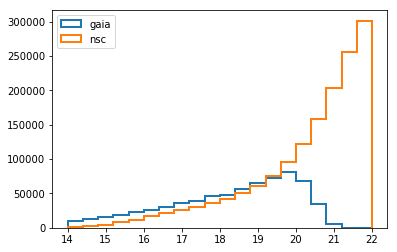

In [40]:
%matplotlib inline
plt.hist(gaia['Gmag'],range=(14,22), histtype='step', lw=2, bins=20,
        label='gaia')
plt.hist(hlc_nsc['gmag'], range=(14,22),histtype='step', lw=2, bins=20,
        label='nsc')
plt.legend(loc='upper left')

Show the histogram of RA coverage : it is similar by construction ... 

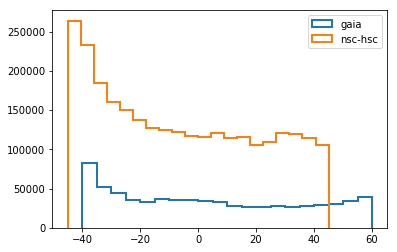

In [41]:
%matplotlib inline 
plt.hist(gaia['raW'] ,histtype='step', lw=2, bins=20,
        label='gaia')
plt.hist(hlc_nsc['raW'],histtype='step', lw=2, bins=20,
        label='nsc-hsc')
plt.legend()

In [30]:
# Match HLC-NSC to gaia 
np.ravel(hlc_nsc.colnames)

# lowercase cols : NSC 
# uppercase  cols  : HLC 

Cross match positionally HLC/NSC to GAIA, using NSC ra,dec 

In [32]:
#hlc_nsc['raW']

In [43]:
# Match NSC/HLC to GAIA 


# To make things faster, we split this range 
# into bins of RA 

ra_col  = 'raW' 
# choose which ra to use :
# 'raW'  is from NSC,  
# and 'RA_MEAN_CLIP_W' is from HLC  catalog 
gaia_comb = Table()
ra = np.arange(-40,60,10)  # every 10 degrees, the range does not 
for i in range(len(ra)-1):   # include the upper limit
    print('Matching ra in range ',ra[i], ra[i+1])
    mask_2 = (ra[i]<hlc_nsc[ra_col])*(hlc_nsc[ra_col] < ra[i+1])
    mask_1 = (ra[i]<gaia['raW'])*(gaia['raW'] < ra[i+1])
    
    cat2_sel = hlc_nsc[mask_2]
    cat1_sel = gaia[mask_1]
    print('GAIA: ',len(cat1_sel),'NSC-HLC:', len(cat2_sel))
    
    # GAIA 
    cat1_coords = SkyCoord(ra=cat1_sel['raW']*u.degree, 
                          dec=cat1_sel['dec']*u.degree
                         )
    # NSC 
    cat2_coords = SkyCoord(ra = cat2_sel[ra_col]*u.degree,  
                          dec = cat2_sel['dec']*u.degree
                         )
    
    idx, d2d, d3d = cat1_coords.match_to_catalog_sky(cat2_coords)  
    
    cats_sel = hstack([cat1_sel, cat2_sel[idx]], table_names = ['gaia', 'hlcnsc'])
    cats_sel['sep_2d_arcsec_gaia-nsc'] = d2d.arcsec
    
    gaia_comb = vstack([cats_sel, gaia_comb])
    
print('Finished crossmatching')    

Matching ra in range  -40 -30
134898 447493
Matching ra in range  -30 -20
80039 331689
Matching ra in range  -20 -10
69616 286653
Matching ra in range  -10 0
70547 266405
Matching ra in range  0 10
66322 263539
Matching ra in range  10 20
55054 248457
Matching ra in range  20 30
53212 250953
Matching ra in range  30 40
53924 261548
Matching ra in range  40 50
58222 117909
Finished crossmatching


641834 549758


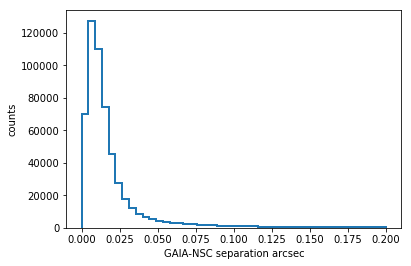

In [90]:
# plot the separation histogram ....
# there is a clean peak close to zero : 
# these are the matched sources 
x = gaia_comb['sep_2d_arcsec_gaia-nsc']
plt.hist(x[x<0.2], histtype='step', lw=2 , bins=45)
plt.xlabel('GAIA-NSC separation arcsec')
plt.ylabel('counts')
plt.savefig('hw2_4_GAIA_NSC_matching.png', bbox_inches='tight')
#  select matched sources 
x = gaia_comb['sep_2d_arcsec_gaia-nsc']
matched = x < 0.5
select =  gaia_comb[matched]

# How many of the GAIA  sources  in the considered RA range had a good match 
# from NSC ? 
print(len(gaia_comb), len(select))

In [48]:
# Save the few most important columns of 
# cross-matched HLC-NSC-GAIA catalog ....
np.save('gaia_nsc-hlc_half_arcsec_'+str(len(select)), select)
# this can be loaded as 
# gaia_comb = Table(np.load(fname))

# It ends up eating only 385 MB - worthy investment ...

## Read the cross-matched GAIA-HLC/NSC catalog... <a id='step3b'></a>

[Go to top](#toc)

In [97]:
# We assume that you first used the cross-matched HLC-NSC catalog,
# took the GAIA S82 data, and since GAIA is shallower, 
# match GAIA to HLC-NSC , based on NSC ra,dec 

# check that  the cross-matched file exists, and if so, 
# read the catalog ...
fname = [x for x in os.listdir() if x.startswith('gaia')]
if len(fname)>0 : 
    print('Reading the cross-matched GAIA-HLC-NSC catalog...')
    select = Table(np.load(fname[0]))
else : 
    print('No cross-matched file that starts with "gaia"... Go to step3a')

Reading the cross-matched GAIA-HLC-NSC catalog...


In [ ]:
# Plot  delta_ra vs delta_dec  , and histograms of delta_ra,  delta_dec 

# for :                  
#  { HLC vs NSC     X      { with  PM_NSC
#    HLC vs Gaia              with PM_HSC ,  
#    NSC vs Gaia }            without correction }

# thus 9 pairs of plots total 
#plt.hist(select['ra'])

In [98]:
# Add a column for the HLC time 
select['t_hlc_jd'] = select['T0_CLIP']+select['TIME_SPAN']/2.0

# remove the unnecessary cols
select.remove_columns(['T0_CLIP','TIME_SPAN'])
# Convert HLC time column from JD to MJD 
t_hlc_jd =  Time(select['t_hlc_jd'], format='jd')
select['t_hlc'] = t_hlc_jd.mjd

# rename NSC column to be more uniform and less confusing
select.rename_column('mjd', 't_nsc')

In [100]:
# GAIA does not have time column : 
# add it drawing time values from the 
# uniform distribution between 
# DR1 beginning and end date, 
# taken from https://www.cosmos.esa.int/web/gaia/dr1 
# "Gaia DR1 is based on observations collected between
# 25 July 2014 and 16 September 2015"


N_obs = len(select)
time_dr1_start = Time('2014-07-25', scale='utc').mjd
time_dr1_end = Time('2015-09-16', scale='utc').mjd
time_dr1_gaia = np.random.uniform(time_dr1_start, time_dr1_end, N_obs)

# add that to the cross-matched catalog
select['t_gaia'] = time_dr1_gaia

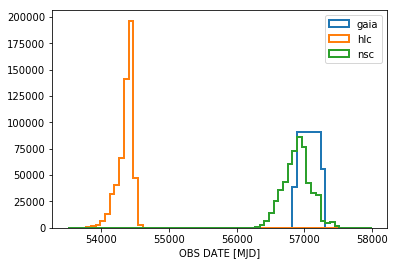

In [102]:
# show that it worked ...
for cat in ['gaia','hlc','nsc']:
    plt.hist(select['t_'+cat],  lw=2, histtype='step',
            range=(53500,58000), bins=65, label=cat)
plt.legend()
plt.xlabel('OBS DATE [MJD]')
plt.savefig('hw2_4_3b_GAIA_NSC_HLC_mjd.png')

So this shows us that while HLC and NSC are separated by quite a bit,  GAIA and NSC are almost not separated at all -it  makes sense to compare HLC-GAIA,   HLC-NSC  with/without proper motion  from either HLC or NSC, but it does not make sense to compare NSC to GAIA, because of too short baseline difference ... 

In [95]:
#select.colnames

In [147]:
# rename this cols since I was really using just 
# the NSC ra,dec  to cross-match with GAIA ... 
select.rename_column('dec_hlcnsc','dec_nsc')
select.rename_column('raW_hlcnsc', 'raW_nsc')

In [144]:
np.ravel(select.colnames)

array(['ra_gaia', 'dec_gaia', 'nObs', 'Gmag', 'flux', 'fluxErr',
       'raW_gaia', 'umagHLC', 'gmagHLC', 'rmagHLC', 'imagHLC', 'zmagHLC',
       'uerrHLC', 'gerrHLC', 'rerrHLC', 'ierrHLC', 'zerrHLC', 'LC_NAME',
       'IAU_NAME', 'N_GOOD_EPOCHS', 'MEAN_PSFMAG', 'MEAN_PSFMAG_ERR',
       'N_GOOD_EPOCHS_PSF_CLIP', 'MEAN_OBJECT_TYPE', 'REDDENING',
       'RA_MEAN_CLIP_W', 'RA_MEAN_ERR_CLIP', 'RA_PM_ERR_CLIP',
       'DEC_MEAN_CLIP', 'DEC_MEAN_ERR_CLIP', 'DEC_PM_ERR_CLIP', 'T0',
       'N_POS_EPOCHS_CLIP', 'ECL_REDCHISQ_OUT', 'ECL_STAT', 'ECL_EPOCH',
       'ra_nsc', 'dec_nsc', 'pmra_nsc', 'pmraerr', 'pmdec_nsc', 'pmdecerr',
       't_nsc', 'deltamjd', 'gmag', 'grms', 'gerr', 'rmag', 'rrms', 'rerr',
       'imag', 'irms', 'ierr', 'class_star', 'fwhm', 'ebv', 'nphot',
       'raW_hlcnsc', 'sep_2d_arcsec_HLC_NSC', 'sep_2d_arcsec_gaia-nsc',
       't_hlc_jd', 't_hlc', 't_gaia', 'pmra_hlc', 'pmdec_hlc'],
      dtype='<U22')

In [104]:
from itertools import product

ra_col={'hlc':'RA_MEAN_CLIP_W', 'nsc':'raW_nsc', 'gaia':'raW_gaia'}
dec_col={'hlc':'DEC_MEAN_CLIP', 'nsc':'dec_nsc', 'gaia':'dec_gaia'}
t_col = {'hlc':'t_hlc', 'nsc':'t_nsc', 'gaia':'t_gaia'}

catalog_pairs = [['hlc','nsc'],
                ['hlc','gaia']]
pm_correction = ['with pm hlc','with pm nsc','without']

# iterate over a cartesian product of 
# left and right tuples 
for catalog_pair, pm in product(catalog_pairs , pm_correction):
    print(catalog_pair, pm)
    cat1,cat2 = catalog_pair
    t1_col,t2_col = t_col[cat1], t_col[cat2]
    ra1_col, ra2_col = ra_col[cat1], ra_col[cat2]
    dec1_col, dec2_col = dec_col[cat1], dec_col[cat2]
    
    
    
# Choose based on SN,  r_mag   from HLC catalog
#mean_psfmag_HLC, mean_psfmag_err_HLC, SN_HLC = FormatMagnitude(gaia_select)

#mSN = (SN['g'] > 5) * ( SN['r'] > 5) * ( SN['i'] > 5 )
#m_r = mean_psfmag['r'].data > 10.0

#dra = 3600*(hlc_nsc['RA_MEAN_CLIP_W'] - hlc_nsc['raW']) 
#ddec = 3600*(hlc_nsc['DEC_MEAN_CLIP'] - hlc_nsc['dec'])

['hlc', 'nsc'] with pm hlc
['hlc', 'nsc'] with pm nsc
['hlc', 'nsc'] without
['hlc', 'gaia'] with pm hlc
['hlc', 'gaia'] with pm nsc
['hlc', 'gaia'] without


In [52]:
# Print histograms of time differences...

['hlc', 'nsc']
['hlc', 'gaia']
['nsc', 'gaia']


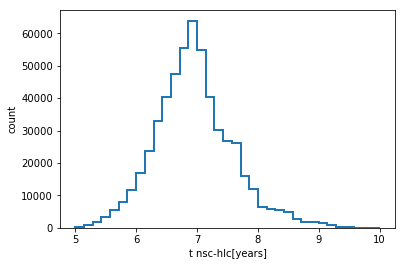

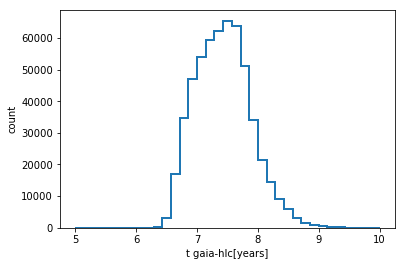

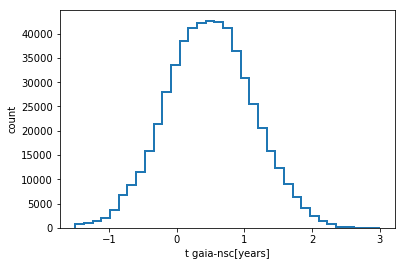

In [113]:
i = 0
bounds = [[5,10],[5,10],[-1.5,3]]
for catalog_pair in [['hlc','nsc'],
                    ['hlc','gaia'],
                    ['nsc','gaia']] : 
    print(catalog_pair)
    
    cat1,cat2 = catalog_pair
    t1_col,t2_col = t_col[cat1], t_col[cat2]
    t1 = Time(select[t1_col],format='mjd')  # this is in MJD 
    t2 = Time(select[t2_col],format='mjd')  # this is in MJD 
    dt_years = (t2.mjd - t1.mjd) / 365
    # plotting  : initialize the figure 
    fig,ax = plt.subplots(1,1, figsize=(6,4))

    # start from the histogram of time differences...
    bound = bounds[i]
    ax.hist(dt_years, lw=2, histtype='step', bins=35, range=bound)
    ax.set_xlabel('t '+cat2+'-'+ cat1+'[years]')
    ax.set_ylabel('count')
    plt.savefig('hw2_4_3b_dt_'+cat2+'-'+ cat1+'.png')
    i+=1
    

In [115]:
# Convert to miliarcsec and rename
select['pmra_hlc'] = 1000*select['RA_PM_CLIP'] # convert to miliarcsec 
select['pmdec_hlc'] = 1000*select['DEC_PM_CLIP'] # convert to miliarcsec 

# remove old cols 
select.remove_columns(['RA_PM_CLIP', 'DEC_PM_CLIP'])

# rename nsc pm 
select.rename_column('pmra','pmra_nsc')
select.rename_column('pmdec','pmdec_nsc')

In [150]:
#pm = pm_correction[2]
#catalog_pair = catalog_pairs[0]


def plot_dra_ddec(catalog_pair,pm, select=select,
                  t_col=t_col, ra_col=ra_col, dec_col=dec_col ):
    cat1,cat2 = catalog_pair
    print('Displaying ra_',cat2,'- ra_',cat1)

    # use appropriate columns for time , 
    # and ra,dec 
    t1_col,t2_col = t_col[cat1], t_col[cat2]
    ra1_col, ra2_col = ra_col[cat1], ra_col[cat2]
    dec1_col, dec2_col = dec_col[cat1], dec_col[cat2]
    # assume : all RA , DEC in degrees, which we convert to miliarcsec 

    # starts with degrees , convert to miliarcseconds 
    degrees_to_miliarcsec =  3600 * 1000

    t1 = Time(select[t1_col],format='mjd')  # this is in MJD 
    ra1 = select[ra1_col]* degrees_to_miliarcsec 
    dec1 = select[dec1_col] * degrees_to_miliarcsec 

    t2 = Time(select[t2_col],format='mjd')  # this is in MJD 
    ra2 = select[ra2_col]* degrees_to_miliarcsec 
    dec2 = select[dec2_col] * degrees_to_miliarcsec 

    # convert the difference from days to years 
    dt_years = (t2.mjd - t1.mjd) / 365

    # uncorrected values 
    dra = ra2 - ra1
    ddec = dec2 - dec1
    # choose whether we use the correction or not 
    if pm == 'with pm hlc':
        print('Using HLC Proper Motions')
        pmra = select['pmra_hlc']
        pmdec = select['pmdec_hlc']
        pm_title= 'using HLC proper motions'

    if pm == 'with pm nsc':
        print('Using NSC Proper Motions')
        pmra = select['pmra_nsc'] # already in miliarcsec 
        pmdec  = select['pmra_nsc']
        pm_title= 'using NSC proper motions'
        
    if pm == 'without':
        print('Without proper motion correction')
        pmra = 0
        pmdec = 0
        pm_title= 'wi proper motions'

    # apply correction ... in miliarcsec : 
    dracorr = pmra * dt_years
    ddeccorr = pmdec * dt_years

    dra = dra + dracorr
    ddec = ddec + ddeccorr


    # plotting  : initialize the figure 
    fig,ax = plt.subplots(1,2, figsize=(12,5.))

    # start from the histogram of time differences...
    r = 300
    im1 = ax[0].hexbin(dra, ddec, bins='log', cmap=plt.cm.viridis,
       mincnt=1, extent=(-r, r, -r,r))
    ax[0].set_xlim(-r,r)
    ax[0].set_ylim(-r,r)
    ax[0].plot([-r,r], [0.0, 0.0], '-k', c='red')
    ax[0].plot([0,0], [-r,r], '-k', c='red')
    ax[0].set_xlabel(r'$\Delta RA \,[miliarcsec]$')
    ax[0].set_ylabel(r'$\Delta DEC \,[miliarcsec]$')

    # Add colorbar 
    #cax = plt.axes([0.82, 0.35, 0.02, 0.6])
    cb = plt.colorbar(im1 , ax=ax[0])
    cb.set_label(r'$\log (N)$')

    for d,l in zip([dra, ddec],[r'$\Delta RA$',r'$\Delta DEC$']):
        #med = np.median(d)
        #dmin, dmax = med-3*sigmaG(d), med+3*sigmaG(d)
        ax[1].hist(d, range=(-300,300), histtype='step', lw=2, bins=45, label=l)
        ax[1].axvline(np.median(d), ls='--', lw=2, c='k')
    ax[1].legend()
    ax[1].set_xlabel(r'$\Delta (RA,DEC) \,[miliarcsec]$')
    plt.subplots_adjust(hspace=0.45)
    fig.suptitle(cat2+'-'+cat1+ pm_title)
    plt.savefig('hw2_4_3b_'+cat2+'-'+cat1+'_dra_ddec.png', bbox_inches='tight')
    # start from the histogram of time differences...
    #ax.hist(abs(dt_years), lw=2, histtype='step', bins=45, range=[1.5  ,6])
    #ax.set_xlabel('t '+cat1+'-'+ cat2+'[years]')
    #ax.set_ylabel('count')
    #x0 = -50
    print('med(dra)='+str(np.median(dra))[:5])
    print('med(ddec)='+str(np.median(ddec))[:5])
    print('sigmaG(dra)='+str(sigmaG(dra))[:5])
    print('sigmaG(ddec)='+str(sigmaG(ddec))[:5])

['hlc', 'nsc'] with pm hlc
Displaying ra_ nsc - ra_ hlc
Using HLC Proper Motions
med(dra)=66.56
med(ddec)=-126.
sigmaG(dra)=137.7
sigmaG(ddec)=116.2
['hlc', 'nsc'] with pm nsc
Displaying ra_ nsc - ra_ hlc
Using NSC Proper Motions
med(dra)=36.60
med(ddec)=-91.7
sigmaG(dra)=135.0
sigmaG(ddec)=100.1
['hlc', 'nsc'] without
Displaying ra_ nsc - ra_ hlc
Without proper motion correction
med(dra)=47.05
med(ddec)=-84.2
sigmaG(dra)=90.05
sigmaG(ddec)=72.98
['hlc', 'gaia'] with pm hlc
Displaying ra_ gaia - ra_ hlc
Using HLC Proper Motions
med(dra)=68.17
med(ddec)=-132.
sigmaG(dra)=141.6
sigmaG(ddec)=120.9
['hlc', 'gaia'] with pm nsc
Displaying ra_ gaia - ra_ hlc
Using NSC Proper Motions
med(dra)=36.55
med(ddec)=-95.7
sigmaG(dra)=139.8
sigmaG(ddec)=103.2
['hlc', 'gaia'] without
Displaying ra_ gaia - ra_ hlc
Without proper motion correction
med(dra)=47.34
med(ddec)=-87.5
sigmaG(dra)=90.18
sigmaG(ddec)=73.48


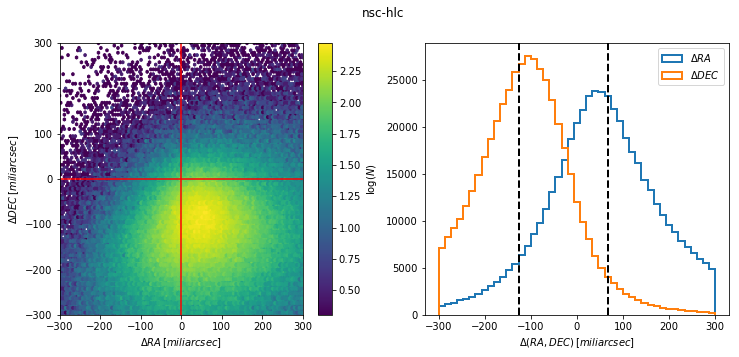

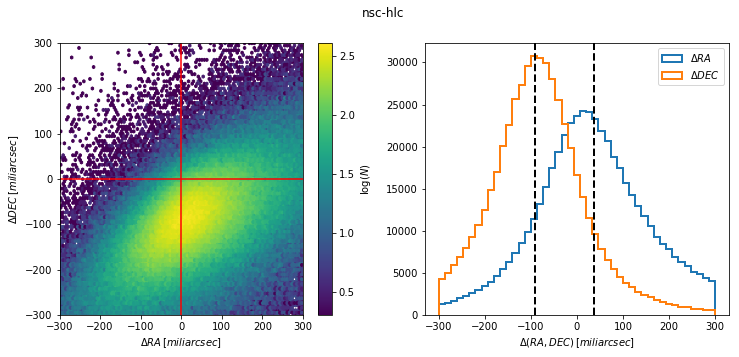

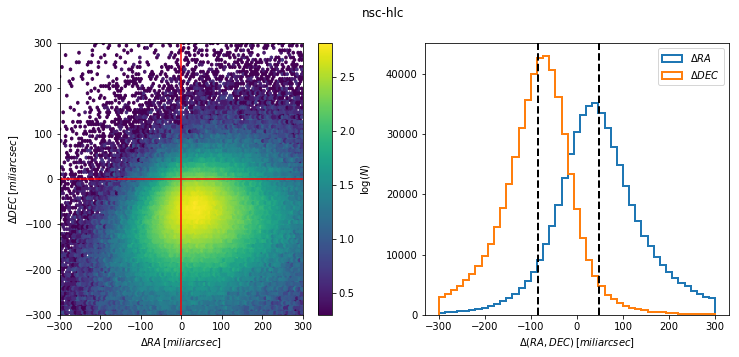

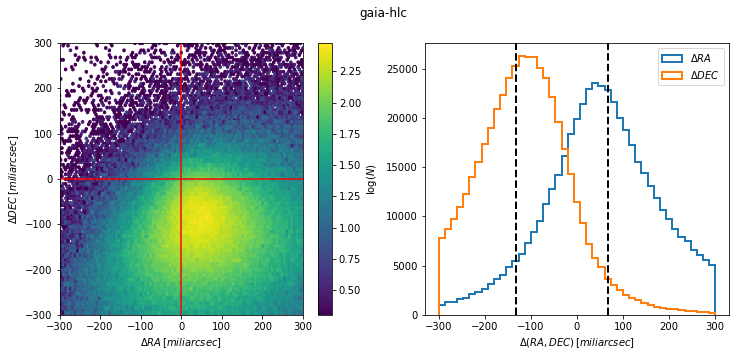

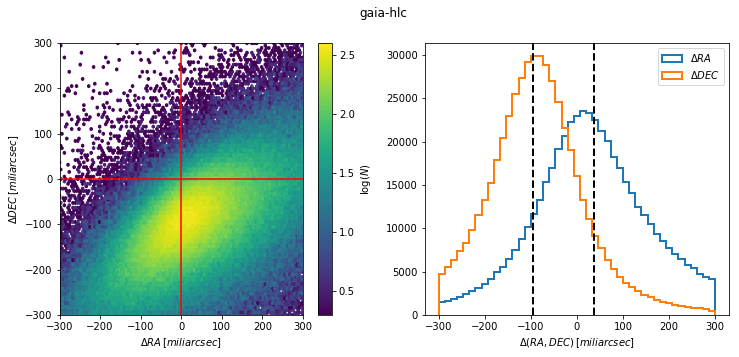

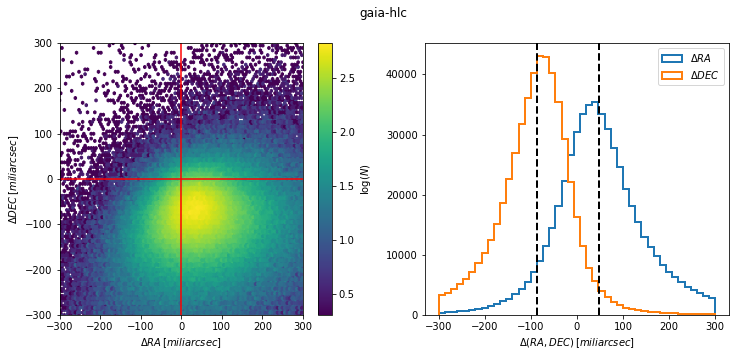

In [151]:
for catalog_pair, pm in product(catalog_pairs , pm_correction):
    print(catalog_pair, pm)
    plot_dra_ddec(catalog_pair,pm)

(array([ 17479.,  26366.,  40362.,  61012.,  82576.,  94556.,  80744.,
         50132.,  24392.,  11186.]),
 array([-234.54558354, -205.15088767, -175.7561918 , -146.36149593,
        -116.96680006,  -87.57210419,  -58.17740832,  -28.78271246,
           0.61198341,   30.00667928,   59.40137515]),
 <a list of 10 Patch objects>)

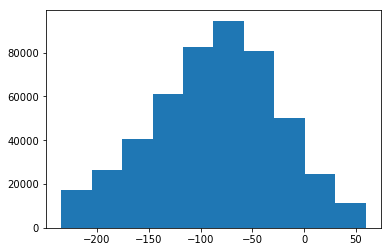

In [126]:

plt.hist(ddec, range=(dmin,dmax))

In [125]:
np.median(ddec)

-87.572104193386622

## 4) Try downloading GAIA data from fatboy  <a id='step4'></a>

[ Go to top ](#toc)

According to Scott Daniel, "There is a `gaia_2016` table on fatboy that contains about 1.1 billion rows.  I vaguely remember creating that table, but cannot vouch for its contents.  If you want to connect with it and play around, you can use the `lsst_sims` stack, connecting via 

    from lsst.sims.catalogs.db import DBObject
    gaia_db = DBObject(database='LSSTCATSIM', host='fatboy.phys.washington.edu', port=1433, driver='mssql+pymssql')

This will connect you to the LSSTCATSIM database.  There are methods for exploring tables, such as

    get_column_names(tableName='gaia_2016')
    
Most of the methods have pretty good docstrings, which should help you learn how to work with the database
"

In [ ]:
# Try the above ... 
from lsst.sims.catalogs.db import DBObject

In [ ]:
DBObject?

In [ ]:
gaia_db = DBObject(database='LSSTCATSIM', host='fatboy.phys.washington.edu', 
                   port=1433, driver='mssql+pymssql')

In [ ]:
np.ravel(gaia_db.get_column_names(tableName='gaia_2016'))

In [ ]:
# So it looks like the table is a beast  
query = '''SELECT ra, dec, pmra 
           FROM gaia_2016
           WHERE (((ra > 315 or ra<45)) and dec > -1.2
            and dec < 1.2  and phot_g_mean_mag > 13 
            and phot_g_mean_mag < 23.0)
          '''

dtype = np.dtype([('ra', float), ('dec', float), ('pmra', float)])

data_iterator = gaia_db.get_arbitrary_chunk_iterator(query,  
                                                     dtype=dtype, 
                                                     chunk_size=10000)


In [ ]:
#Get the first chunk..

for chunk in data_iterator : 
    print(Table(chunk))
    break 


In [ ]:
%matplotlib inline
plt.scatter(chunk['ra'], chunk['dec'])

Looks like working with GAIA catalog is more complicated, need more time to figure out how to get all the S82 data into AstroPy table that we could then use ...